<a href="https://colab.research.google.com/github/mcatrinque/areas-cep-mg/blob/main/heuristica_construtiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Heurística Construtiva

## Carrega Bibliotecas

In [1]:
import math
import time
import os

import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

from google.colab import drive

## Carregamento dos Arquivos de Entrada

In [2]:
drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/Colab Notebooks/Heuristica/EUC_2D'
cities = []

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Funções de Tratamento

As instâncias fornecidas podem ser classificadas em dois tipos: aquelas em que a distância entre os pontos segue o modelo euclidiano (EUC_2D) e aquelas em que a distância segue o modelo pseudo-euclidiano (ATT). Consequentemente, o cálculo da distância entre os pontos varia de acordo com o tipo de instância.

### Distância euclidiana
Suponha que as coordenadas de um ponto i sejam representadas por x[i] e y[i]. Ao calcular a distância entre dois pontos i e j para as arestas do tipo EUC_2D (distância euclidiana).


In [3]:
def euclidean_distance_2d(src, trg):
    xd = src[0] - trg[0]
    yd = src[1] - trg[1]
    return round(math.sqrt(xd * xd + yd * yd))

### Distância ATT
Se considerarmos x[i] e y[i] como as coordenadas de um ponto i, ao calcular a distância entre dois pontos i e j para as arestas do tipo ATT (distância pseudo euclidiana).





In [4]:
def att_distance(src, trg):
    xd = src[0] - trg[0]
    yd = src[1] - trg[1]
    rij = math.sqrt((xd * xd + yd * yd) / 10.0)
    tij = round(rij)
    if tij < rij:
        return tij + 1
    else:
        return tij

### Distância entre cidades
Calcula a distância entre duas cidades com base no tipo de distância

In [5]:
def calculate_distance(dist, src, trg):
    if dist:
        return euclidean_distance_2d(src, trg)
    else:
        return att_distance(src, trg)

### Validação de distância euclidiana
Avaliar se o tipo de distância é euclidiana (EUC_2D)


In [6]:
def is_euclidean_distance(d):
    return d == "EUC_2D"

## Heurística de Vizinhos mais Próximos
A função `nearest_neighbor_algorithm` implementa a heurística do "Vizinho Mais Próximo" para resolver o Problema do Caixeiro Viajante (TSP, sigla em inglês). O objetivo do TSP é encontrar o caminho mais curto que visita cada cidade exatamente uma vez e retorna à cidade de origem.

A heurística do "Vizinho Mais Próximo" é uma abordagem gulosa, onde o algoritmo começa em uma cidade inicial e, a cada passo, seleciona a cidade não visitada mais próxima para visitar em seguida.

A heurística funciona da seguinte forma:

1. Inicialização:
   - Comece a partir de uma cidade inicial (geralmente a primeira cidade na lista de cidades).
   - Marque essa cidade como visitada e defina o custo inicial como zero.

2. Seleção do próximo vizinho:
   - Enquanto não todas as cidades forem visitadas:
     - Inicialize a distância auxiliar (`aux_dist`) como infinito.
     - Percorra todas as cidades não visitadas (exceto a cidade atual) e calcule a distância entre a cidade atual e as cidades vizinhas.
     - Se a distância calculada for menor que a distância auxiliar, atualize a distância auxiliar e registre a cidade vizinha como a candidata a ser visitada em seguida.
     - Marque a cidade candidata como visitada.
     - Atualize o custo acumulativo.

3. Conclusão:
   - Depois de visitar todas as cidades, adicione a distância da última cidade visitada de volta à cidade de origem.
   - Retorne o custo total da rota encontrada.

Esta heurística não garante uma solução ótima, mas é eficaz para encontrar soluções aproximadas em um tempo razoável. A qualidade da solução depende da escolha da cidade inicial e da ordem em que as cidades são visitadas. Em alguns casos, a heurística pode fornecer uma solução próxima da ótima, mas em outros, pode estar longe da solução ideal. A escolha da cidade inicial é um dos fatores críticos para o desempenho da heurística.

In [7]:
def nearest_neighbor_algorithm(dist):
    cost = 0
    n_visited = 0
    current_city = 0
    visited = [0] * len(cities)
    visited[0] = 1
    n_visited += 1

    while n_visited != len(cities):
        aux_dist = float("inf")
        for i in range(len(cities)):
            if not visited[i] and i != current_city:
                cd = calculate_distance(dist, cities[current_city], cities[i])
                if aux_dist > cd:
                    aux_dist = cd
                    candidate_city = i
                    aux_cost = cd
        visited[candidate_city] += 1
        n_visited += 1
        cost += aux_cost
        current_city = candidate_city

    cost += calculate_distance(dist, cities[current_city], cities[0])
    return cost

## Análise e Resultados

### Leitura de arquivos de entrada
Responsável por extrair informações importantes de um arquivo de entrada relacionado ao TSP.

Essa função determina o número de cidades, o tipo de distância (euclidiana ou pseudo euclidiana) e as coordenadas das cidades.

Os dados são usados posteriormente no algoritmo de resolução do TSP, que pode ser implementado usando a heurística do Vizinho Mais Próximo.

A escolha do algoritmo de resolução e a manipulação dessas informações dependem do contexto em que a função é usada.






In [8]:
def read_input_content(content):
    n_cities = 0
    distance = False
    lines = content.split('\n')

    for i, line in enumerate(lines):
        parts = line.strip().split(":")
        if parts[0] == "DIMENSION":
            n_cities = int(parts[1])
        elif parts[0] == "EDGE_WEIGHT_TYPE":
            distance = is_euclidean_distance(parts[1])

        if parts[0] == "NODE_COORD_SECTION":
            break

    for line in lines[i+1:]:
        if line.strip() == "EOF":
            break
        parts = line.strip().split()
        if len(parts) >= 3:
            index, x_coordinate, y_coordinate = map(float, parts[:3])
            cities.append((x_coordinate, y_coordinate))

    return n_cities, distance

### Processamento de arquivos em lote
Os resultados obtidos a partir da heuristica de vizinhos próximos serão exibidos conforme a leitura das instâncias fornecidas acontece:

In [9]:
def process_tsp_files(folder_path):
    start = time.time()
    results = []
    file_list = os.listdir(folder_path)

    for filename in file_list:
        if filename.endswith(".tsp"):
            file_path = os.path.join(folder_path, filename)

            with open(file_path, 'r') as infile:
                n_cities, distance = read_input_content(infile.read())
            cost = nearest_neighbor_algorithm(distance)

            result = {
                "Arquivo": filename,
                "Resultado": cost
            }
            results.append(result)

    end = time.time()
    time_taken = end - start
    print(f"Tempo de execução total: {time_taken} segundos")

    return results

df = pd.DataFrame(process_tsp_files(folder_path))
df

Tempo de execução total: 37.801143407821655 segundos


,Arquivo,Resultado
0,kroD100.tsp,8571
1,kroB200.tsp,12871
2,kroE100.tsp,15350
3,pr152.tsp,42154
4,pr144.tsp,52316
5,pr124.tsp,63474
6,kroA150.tsp,68919
7,kroB150.tsp,67327
8,kroB100.tsp,67327
9,pr136.tsp,86714


### Visualização de resultados
Gera um gráfico de barras para representar o desempenho de resultado da heurística aplicada ante a cada instância proposta:

In [10]:
def plot_interactive_result(results):

    fig = px.bar(
        df,
        x="Arquivo",
        y="Resultado",
        labels={"Arquivo": "Arquivo", "Resultado": "Resultado"},
        title="Desempenho do Algoritmo do Vizinho Mais Próximo",
        color="Arquivo"
    )

    fig.update_xaxes(tickangle=45)
    fig.show()
plot_interactive_result(df)

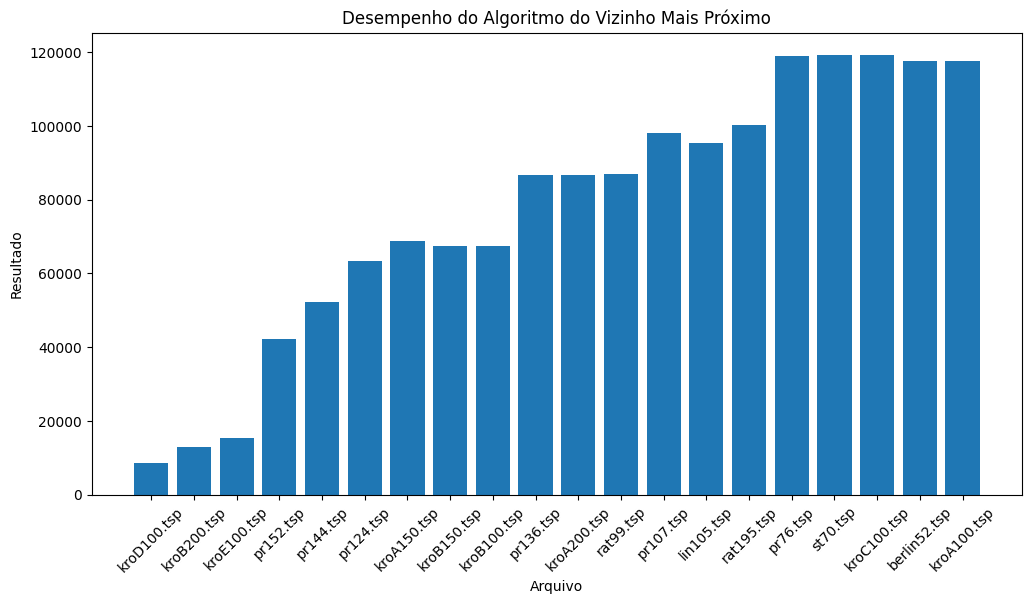

In [11]:
def plot_interactive_result(df):
    plt.figure(figsize=(12, 6))
    plt.bar(df["Arquivo"], df["Resultado"])
    plt.xlabel("Arquivo")
    plt.ylabel("Resultado")
    plt.title("Desempenho do Algoritmo do Vizinho Mais Próximo")
    plt.xticks(rotation=45)
    plt.show()

# Certifique-se de que `df` já foi definido ou passe o DataFrame como argumento da função
plot_interactive_result(df)